<a href="https://colab.research.google.com/github/kvin-alxndr/bayes-classification/blob/main/Practica2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificador Bayesiano de pixeles por color

# Entrenamiento

In [ ]:
from numpy.core.multiarray import dot
import numpy as np
import cv2 as cv
import os

#Listas que guardan los promedios de los valores RGB y pixeles para cada clase
#Y las matrices de covarianza para cada imagen de entrenamiento
datos_platanos=[]
matrices_platanos = []

datos_chiles=[]
matrices_chiles = []

datos_huevos=[]
matrices_huevos = []

datos_fondo=[]
matrices_fondo = []

#Rangos de colores para la obtención de la máscara de cada clase
color_max_p = np.array([235,220,120])
color_min_p = np.array([160,130,5])

color_max_h = np.array([255,255,255])
color_min_h = np.array([200,170,170])

color_max_c = np.array([86,255,255])
color_min_c = np.array([10,15,0])

color_max_f = np.array([245,125,145])
color_min_f = np.array([100,15,30])

#Función que crea la máscara de cada clase
def crear_mascara(img_gaus,colorMin,colorMax):
    mascara = cv.inRange(img_gaus,colorMin,colorMax)
    return mascara

#Función que devuelve la region de interes
def img_roi(img_gaus,mascara):
    img = cv.bitwise_and(img_gaus, img_gaus, mask=mascara)
    return img

#Función que calcula el promedio de pixeles por canal y la cantidad total
#de pixeles y la matriz de covarianza individual
def rgbmean_pixelnum(roi_img, img):
    obj = np.all(roi_img != [0,0,0],axis=-1)
    r = roi_img[obj, 0]
    g = roi_img[obj, 1]
    b = roi_img[obj, 2]
    rgb = np.array([r,g,b])
    matriz_cov = np.cov(rgb)
    r_mean = np.mean(r)
    g_mean = np.mean(g)
    b_mean = np.mean(b)
    obj_pix = np.count_nonzero(roi_img)
    alto, ancho, _ = img.shape
    pix_tot = alto*ancho
    vec = [r_mean,g_mean,b_mean,obj_pix,pix_tot]
    return vec, matriz_cov

#Función para calcular la media total para los canales y la probabilidad total
def rgbtotal_prob(datos):
    i,r_total,g_total,b_total,pix_total = 0, 0, 0, 0, 0
    while(i<len(datos)):
      r_total += datos[i][0]
      g_total += datos[i][1]
      b_total += datos[i][2]
      pix_total += datos[i][3]
      i+=1
    r_mean_t = r_total/len(datos)
    g_mean_t = g_total/len(datos)
    b_mean_t = b_total/len(datos)
    prob = pix_total/(datos[0][4]*len(datos))
    vec = [r_mean_t,g_mean_t,b_mean_t,prob]
    return vec

#Función que calcula la matriz de covarianza total
def matriz_tot(matrices):
  i = 0
  matriz_aux=[[0,0,0],[0,0,0],[0,0,0]]
  while(i<len(matrices)):
    matriz_aux += matrices[i]
    i+=1
  matriz_total = matriz_aux/len(matrices)
  return matriz_total

#Obtención de datos de todas las imágenes de entrenamiento
imagenes = os.listdir('Resources')
for imagen in imagenes:
     if imagen.endswith('.jpg'):

        ruta_entrada = os.path.join('Resources', imagen)
        img_actual = cv.imread(ruta_entrada)
        img_actual_rgb = cv.cvtColor(img_actual, cv.COLOR_BGR2RGB)
        img_actual_gaus = cv.GaussianBlur(img_actual_rgb,(25,25),cv.BORDER_DEFAULT)


        if imagen is not None:

          mascara_actual_platano = crear_mascara(img_actual_gaus, color_min_p, color_max_p)
          mascara_actual_huevo = crear_mascara(img_actual_gaus, color_min_h, color_max_h)
          mascara_actual_chile = crear_mascara(img_actual_gaus, color_min_c, color_max_c)
          mascara_actual_fondo = crear_mascara(img_actual_gaus, color_min_f, color_max_f)

          roi_actual_f = img_roi(img_actual_gaus, mascara_actual_fondo)
          info_roi_f,matriz_actual = rgbmean_pixelnum(roi_actual_f,img_actual_rgb)
          datos_fondo.append(info_roi_f)
          matrices_fondo.append(matriz_actual)

          roi_actual_p = img_roi(img_actual_gaus, mascara_actual_platano)
          info_roi_p,matriz_actual = rgbmean_pixelnum(roi_actual_p,img_actual_rgb)
          datos_platanos.append(info_roi_p)
          matrices_platanos.append(matriz_actual)

          roi_actual_h = img_roi(img_actual_gaus, mascara_actual_huevo)
          info_roi_h,matriz_actual = rgbmean_pixelnum(roi_actual_h,img_actual_rgb)
          datos_huevos.append(info_roi_h)
          matrices_huevos.append(matriz_actual)

          roi_actual_c = img_roi(img_actual_gaus, mascara_actual_chile)
          info_roi_c,matriz_actual = rgbmean_pixelnum(roi_actual_c,img_actual_rgb)
          datos_chiles.append(info_roi_c)
          matrices_chiles.append(matriz_actual)







#Obtención de las medias totales, probabilidades y matriz de covarianza final
total_platano = rgbtotal_prob(datos_platanos)
vector_platano = np.array([total_platano[0], total_platano[1], total_platano[2]])
prob_platano = total_platano[3]
matriz_covp = matriz_tot(matrices_platanos)

total_chile = rgbtotal_prob(datos_chiles)
vector_chile = np.array([total_chile[0], total_chile[1], total_chile[2]])
prob_chile = total_chile[3]
matriz_covc = matriz_tot(matrices_chiles)

total_huevo = rgbtotal_prob(datos_huevos)
vector_huevo = np.array([total_huevo[0], total_huevo[1], total_huevo[2]])
prob_huevo = total_huevo[3]
matriz_covh = matriz_tot(matrices_huevos)

total_fondo = rgbtotal_prob(datos_fondo)
vector_fondo = np.array([total_fondo[0], total_fondo[1], total_fondo[2]])
prob_fondo = total_fondo[3]
matriz_covf = matriz_tot(matrices_fondo)
total_fondo[3]=1-(total_platano[3]+total_chile[3]+total_huevo[3])

print(f'Media de valores RGB para la clase Platano y probabilidad a priori: {total_platano}')
print(f'Matriz de covarianza para la clase Platano:\n {matriz_covp}\n')

print(f'Media de valores RGB para la clase Chile y probabilidad a priori: {total_chile}')
print(f'Matriz de covarianza para la clase Chile:\n {matriz_covc}\n')

print(f'Media de valores RGB para la clase Huevo y probabilidad a priori: {total_huevo}')
print(f'Matriz de covarianza para la clase Huevo:\n {matriz_covh}\n')

print(f'Media de valores RGB para la clase Fondo y probabilidad a priori: {total_fondo}')
print(f'Matriz de covarianza para la clase Fondo:\n {matriz_covf}\n')


Media de valores RGB para la clase Platano y probabilidad a priori: [216.15414350939915, 192.67950381065003, 60.06479686124904, 0.351625]
Matriz de covarianza para la clase Platano:
 [[169.01416785 246.55906884 128.9696746 ]
 [246.55906884 472.41051076 226.29452001]
 [128.9696746  226.29452001 325.31947652]]

Media de valores RGB para la clase Chile y probabilidad a priori: [55.95304390382161, 83.6458231097394, 23.43183601297318, 0.11149166666666667]
Matriz de covarianza para la clase Chile:
 [[206.50707955  87.50301139  91.38292901]
 [ 87.50301139 487.51370616 270.58348381]
 [ 91.38292901 270.58348381 243.84951636]]

Media de valores RGB para la clase Huevo y probabilidad a priori: [231.42149598690463, 229.8742208771586, 230.9637431707871, 0.20995]
Matriz de covarianza para la clase Huevo:
 [[ 69.07362873 126.16574171 135.51847824]
 [126.16574171 285.4491109  310.86730441]
 [135.51847824 310.86730441 343.71634171]]

Media de valores RGB para la clase Fondo y probabilidad a priori: [22


# Clasificación Naive-Bayes

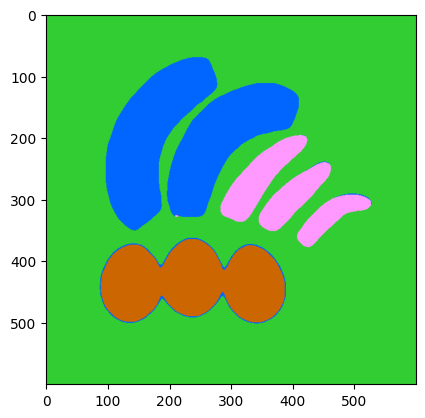

In [ ]:

import matplotlib.pyplot as plt

# ... (definición de variables y funciones) ...
from traitlets.traitlets import Int

# Definición de los parámetros para cada clase
parametros = {
    'PLATANO': {'media': vector_platano, 'covarianza': matriz_covp, 'probabilidad' : prob_platano},
    'HUEVO': {'media': vector_huevo, 'covarianza': matriz_covh, 'probabilidad' : prob_huevo},
    'CHILE': {'media': vector_chile, 'covarianza': matriz_covc, 'probabilidad' : prob_chile},
    'FONDO': {'media': vector_fondo, 'covarianza': matriz_covf, 'probabilidad' : prob_fondo}
}

clase_resultante = None  # Inicialización de la clase resultante
clases = ['PLATANO', 'HUEVO', 'CHILE', 'FONDO']  # Lista de clases posibles

# Cargar la imagen de prueba y realizar preprocesamiento
img_prueba = cv.imread('Resources/Test/Prueba1.jpg')
img_prueba = cv.cvtColor(img_prueba, cv.COLOR_BGR2RGB)  # Convertir a formato RGB
img_gaus = cv.GaussianBlur(img_prueba, (25, 25), cv.BORDER_DEFAULT)  # Aplicar desenfoque gaussiano
img_res = np.zeros((600, 600, 3)).astype(int)  # Crear una imagen resultante vacía con dimensiones 600x600

alto, ancho, canales = img_gaus.shape  # Obtener dimensiones de la imagen

# Función para asignar color a cada clase
def ch_color(clase_res):
    r,g,b = 0, 0, 0
    if clase_res == 'PLATANO':
        r, g, b = 0, 102, 255
    elif clase_res == 'HUEVO':
        r, g, b = 204, 102, 0
    elif clase_res == 'CHILE':
        r, g, b = 255, 153, 255
    elif clase_res == 'FONDO':
        r, g, b = 50, 205, 50
    else:
        r,g,b = 0, 0, 0
    return (r,g,b)


# Función para clasificar un píxel dado usando Naive Bayes
def naive_bayes(entrada, clase):
    # x representa el valor del píxel actual
    x = entrada
    # Obtenemos la matriz de covarianza inversa para la clase dada
    cov_inv = np.linalg.inv(parametros[clase]['covarianza'])
    # Obtenemos la media para la clase dada
    media = parametros[clase]['media']
    # Obtenemos la probabilidad a priori para la clase dada
    proba_apriori = parametros[clase]['probabilidad']
    # Calculamos la diferencia entre el valor del píxel actual y la media de la clase
    x_minus_media = x - media
    # Calculamos el exponente de la fórmula de Naive Bayes
    exponente = -0.5 * np.dot(x_minus_media.T, np.dot(cov_inv, x_minus_media))
    # Calculamos la probabilidad usando la fórmula de Naive Bayes
    proba = np.log(proba_apriori) + exponente - 0.5 * np.log(np.linalg.det(parametros[clase]['covarianza']))
    # Devolvemos la probabilidad de que el píxel pertenezca a la clase dada
    return proba

# ... (código principal) ...

# Bucle para clasificar cada píxel de la imagen
for y in range(alto):
    for x in range(ancho):
        pixel_actual = img_gaus[y, x]  # Obtener el valor de píxel actual

        max_probabilidad = -np.inf  # Inicializar la máxima probabilidad para la clase actual
        clase_resultante = None  # Inicializar la clase resultante para el píxel actual

        # Iterar sobre todas las clases y calcular la probabilidad para cada una
        for clase in clases:
            probabilidad = naive_bayes(pixel_actual, clase)
            if probabilidad > max_probabilidad:
                max_probabilidad = probabilidad
                clase_resultante = clase

        # Asignar color correspondiente según la clase con la máxima probabilidad
        img_res[y, x] = ch_color(clase_resultante)

# Mostrar la imagen resultante
plt.imshow(img_res)
plt.show()

# Clasificación con Scikit

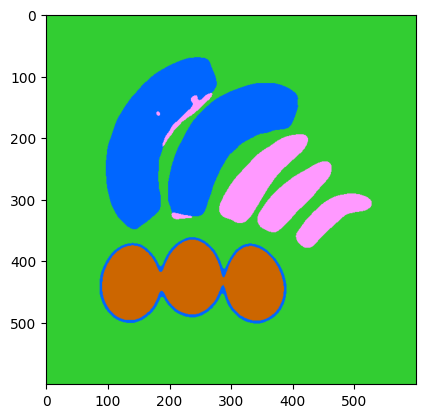

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB

from traitlets.traitlets import Int

# Definición de los parámetros para cada clase
parametros = {
    'PLATANO': {'media': vector_platano, 'covarianza': matriz_covp, 'probabilidad' : prob_platano},
    'HUEVO': {'media': vector_huevo, 'covarianza': matriz_covh, 'probabilidad' : prob_huevo},
    'CHILE': {'media': vector_chile, 'covarianza': matriz_covc, 'probabilidad' : prob_chile},
    'FONDO': {'media': vector_fondo, 'covarianza': matriz_covf, 'probabilidad' : prob_fondo}
}

max_probabilidad = -1  # Valor mínimo para la probabilidad
clase_resultante = None  # Inicialización de la clase resultante
clases = ['PLATANO', 'HUEVO', 'CHILE', 'FONDO']  # Lista de clases posibles

# Cargar la imagen de prueba y realizar preprocesamiento
img_prueba = cv2.imread('Resources/Test/Prueba1.jpg')
img_prueba = cv2.cvtColor(img_prueba, cv2.COLOR_BGR2RGB)  # Convertir a formato RGB
img_gaus = cv2.GaussianBlur(img_prueba, (25, 25), cv2.BORDER_DEFAULT)  # Aplicar desenfoque gaussiano
img_res = np.zeros((600, 600, 3)).astype(int)  # Crear una imagen resultante vacía con dimensiones 600x600

alto, ancho, canales = img_gaus.shape  # Obtener dimensiones de la imagen

# Función para asignar color a cada clase
def ch_color(clase_res):
    r,g,b = 0, 0, 0
    if clase_res == 'PLATANO':
        r, g, b = 0, 102, 255
    elif clase_res == 'HUEVO':
        r, g, b = 204, 102, 0
    elif clase_res == 'CHILE':
        r, g, b = 255, 153, 255
    elif clase_res == 'FONDO':
        r, g, b = 50, 205, 50
    else:
        r,g,b = 0, 0, 0
    return (r,g,b)

# Generar muestras para cada clase utilizando las matrices de covarianza
muestras_platano = np.random.multivariate_normal(vector_platano, matriz_covp, size=100)
muestras_huevo = np.random.multivariate_normal(vector_huevo, matriz_covh, size=100)
muestras_chile = np.random.multivariate_normal(vector_chile, matriz_covc, size=100)
muestras_fondo = np.random.multivariate_normal(vector_fondo, matriz_covf, size=100)

# Preparar los datos de entrenamiento y etiquetas
X_train = np.vstack((muestras_platano, muestras_huevo, muestras_chile, muestras_fondo))
y_train = np.array(['PLATANO'] * 100 + ['HUEVO'] * 100 + ['CHILE'] * 100 + ['FONDO'] * 100)

# Crear un clasificador Naive Bayes Gaussiano
clf = GaussianNB()

# Entrenar el clasificador
clf.fit(X_train, y_train)


# Bucle para clasificar píxeles
for y in range(alto):
    for x in range(ancho):
        pixel_actual = img_gaus[y, x]
        pixel_actual = pixel_actual.reshape(1, -1)  # Reshape para que tenga la forma adecuada

        # Predecir la clase utilizando el clasificador Naive Bayes
        clase_resultante = clf.predict(pixel_actual)
        clase_resultante = clase_resultante[0]  # Extraer la clase resultante de la predicción

        # Asignar color correspondiente según la clase resultante
        img_res[y, x] = ch_color(clase_resultante)

# Mostrar imagen resultante
plt.imshow(img_res)
plt.show()